<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [What are Light Curve Files?](01.03-Investigating-LC-Files.ipynb) | [Contents](index.ipynb) | [Limb Darkening](01.05-Limb-Darkening.ipynb) >

# Folding a Light Curve

Now that we can open a light curve file and plot a light curve, we are able to see the planet transit. In the file we opened in the last notebook the transit is large and clear. We should easily be able to find a period that would be useful to fold on. Let's redraw the light curve using PyKE.

/Users/ch/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/ch/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Found the following flux columns: SAP_FLUX, SAP_FLUX_ERR, PDCSAP_FLUX, PDCSAP_FLUX_ERR
Using data column PDCSAP_FLUX on the plot...
Writing output file data/kplr006922244-2010078095331_llc-kepdraw.png...


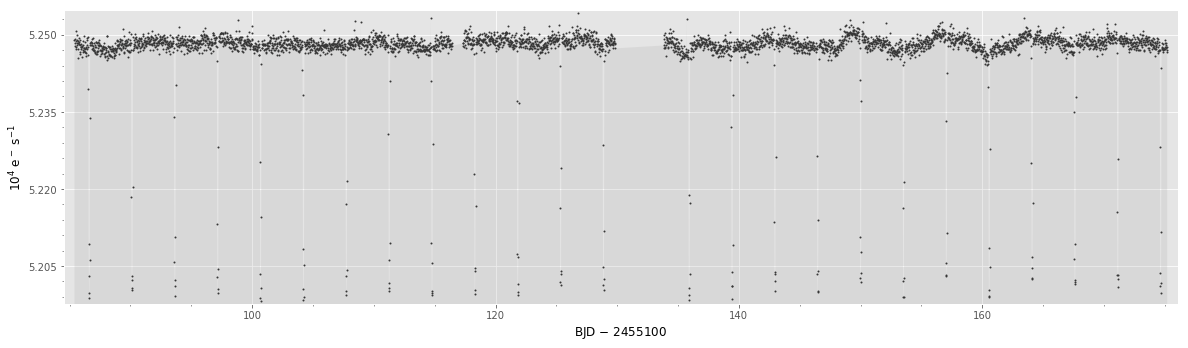

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pyke import kepdraw
from pyke import periodogram
kepdraw('data/kplr006922244-2010078095331_llc.fits')

We'll go through finding the period and folding the light curve with two different approaches, firstly using python, and secondly using the command line.

## Python

Because the transit is so obvious and above the noise we are able to use a a simple period finding algorithm to find the transit period. We'll use *gatspy* to find the period. We'll use some bounds so that the period finding algorithm doesn't find spurious signals. The period for this planet should be between $\approx$0.2-10 days.

First off we'll import the data 

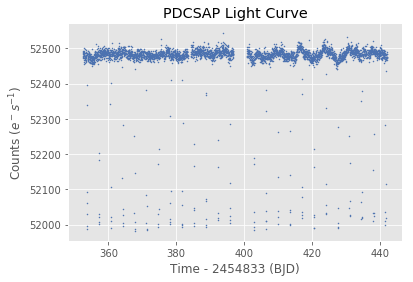

In [53]:
from pyke import lightcurve as lcf
import numpy as np
from astropy.stats import LombScargle
lc = lcf.KeplerLightCurveFile('data/kplr006922244-2010078095331_llc.fits',quality_mask='hard')
t = lc.time
flux = lc.get_lightcurve('PDCSAP_FLUX').flux
t,flux=t[np.isfinite(flux)],flux[np.isfinite(flux)]
plt.scatter(t,flux,s=1)
plt.xlabel('Time - 2454833 (BJD)')
plt.ylabel('Counts ($e^-s^{-1}$)')
plt.title('PDCSAP Light Curve')

Now we'll use *astropy*'s LombScargle routine to find the best period. You can read more about Lomb Scargle fitting [here](). This routine fits sinusoids and finds the best fitting periods.

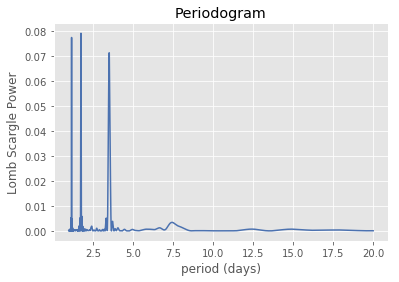

In [54]:
frequency, power = LombScargle(t, flux, flux.max()-flux.min(),nterms=1).autopower(maximum_frequency=1./1,minimum_frequency=1./20,samples_per_peak=40)
best_period = 1./frequency[np.argmax(power)]

fig, ax = plt.subplots()
ax.plot(1./frequency, power)
ax.set(xlabel='period (days)', ylabel='Lomb Scargle Power')
plt.title('Periodogram')

Above is the periodogram. The peaks show us where there is a best fit sinusoid. There are several peaks due to windowing effects. We can now fold the light curve at the best fitting period. This can be done by simply taking the modulus of the time of each observation with the period we've found. 

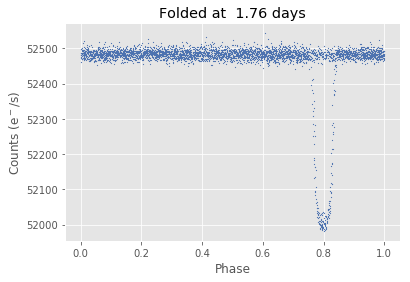

In [56]:
phase = t / best_period % 1
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')
plt.title('Folded at {:5.3} days'.format(best_period))

While this has folded to a harmonic of the correct period, this is actually half the period of the planet. Often algorithms will find a period that is half that of the true period, particularly due to deep secondary eclipses. We can rectify this by doubling the period

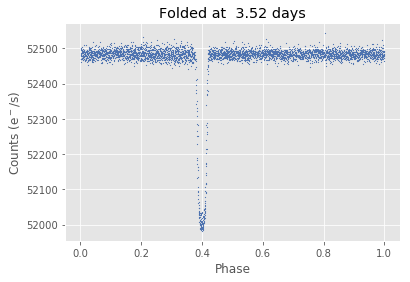

In [57]:
phase = t / (best_period*2) % 1
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')
plt.title('Folded at {:5.3} days'.format(best_period*2))

# But wait, PyKE will do this for you!

Now that you understand how period finding works you can use the inbuilt PyKE routine to find periods in your light curve file as shown below.

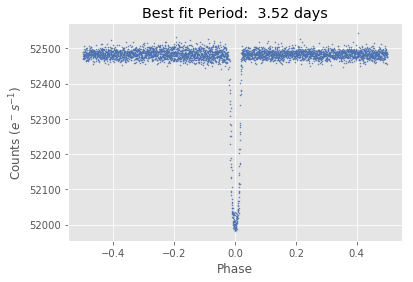

In [58]:
lc = lcf.KeplerLightCurveFile('data/kplr006922244-2010078095331_llc.fits',quality_mask='hard')
lc = lc.fold('PDCSAP_FLUX',minper=1,maxper=20,double=True,plot=True)

## Bash/Command Line

Now we will use command line to do the same with PyKE. This time rather than using *gatspy* to create a quick period we will use a full BLS algorithm to find the period. This will be explained in more detail in a further notebook. We've set the minimum period and the maximum period to small values to save on time.

In [59]:
%%bash
kepflatten data/kplr006922244-2010078095331_llc.fits --overwrite

Writing output file data/kplr006922244-2010078095331_llc-kepflatten.fits...


/Users/ch/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
100%|██████████| 180/180 [00:03<00:00, 49.24it/s]


In [60]:
%%bash 
kepft data/kplr006922244-2010078095331_llc-kepflatten.fits --pmin 2 --pmax 4 --overwrite

Traceback (most recent call last):
  File "/Users/ch/anaconda/bin/kepft", line 11, in <module>
    load_entry_point('pyketools', 'console_scripts', 'kepft')()
  File "/Users/ch/anaconda/lib/python3.6/site-packages/pkg_resources/__init__.py", line 570, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/Users/ch/anaconda/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2750, in load_entry_point
    raise ImportError("Entry point %r not found" % ((group, name),))
ImportError: Entry point ('console_scripts', 'kepft') not found


In [61]:
%%bash
kepfold data/kplr006922244-2010078095331_llc-kepflatten-kepft.fits --bjd0 1 --overwrite --non-interactive 

/Users/ch/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


*kepfold* has produced the following image.
![alt](data/kplr006922244-2010078095331_llc-kepflatten-kepft-kepfold.png)

<!--NAVIGATION-->
< [What are Light Curve Files?](01.03-Investigating-LC-Files.ipynb) | [Contents](index.ipynb) | [Limb Darkening](01.05-Limb-Darkening.ipynb) >